In [2]:
from copy import deepcopy
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

from netam import framework, models, experiment
from netam.common import pick_device, parameter_count_of_model
from netam.framework import load_shmoof_dataframes

%reload_ext autoreload

In [3]:
data_path = "/Users/matsen/data/greiff-systems-oof_pcp_2023-11-30_MASKED.csv"
df = pd.read_csv(data_path, index_col=0)

df = df[df["parent"] != df["child"]]

frac_long_seqs = (df["parent"].str.len() > 410).sum() / len(df)
print(f"Fraction of long sequences: {frac_long_seqs:.2g}")

Fraction of long sequences: 0.0048


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def mutation_count_of_row(row):    
    return sum(
        1 for p, c in zip(row["parent"], row["child"]) if p != c and p != "N" and c != "N"
    )    

df['mutation_count'] = df.apply(mutation_count_of_row, axis=1)


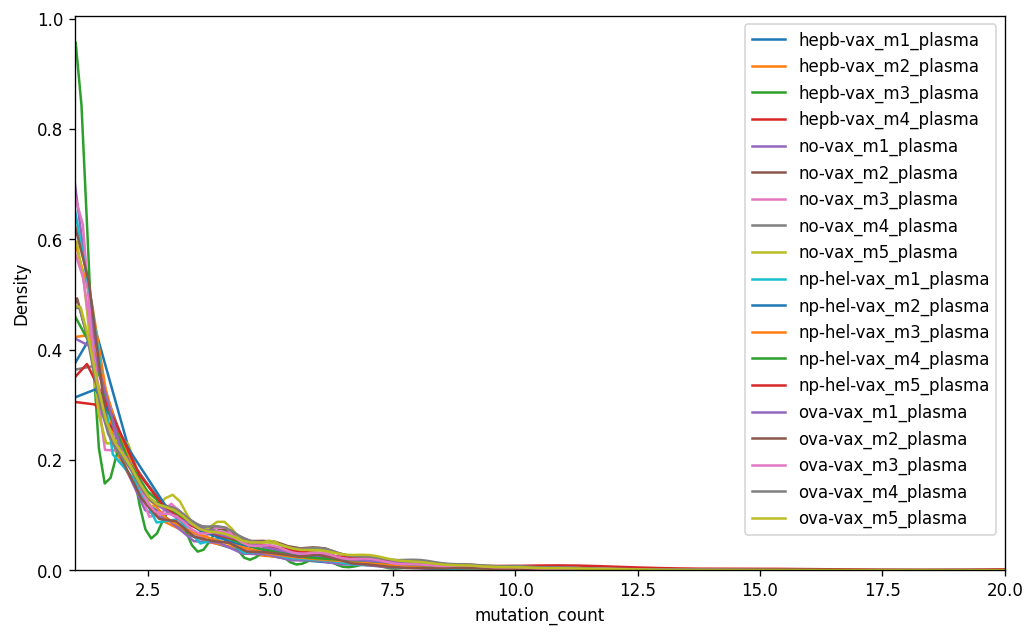

In [5]:

# make a kdeplot of the mutation count with one line per sample_id
fig, ax = plt.subplots(figsize=(10, 6))
for sample_id in df["sample_id"].unique():
    sns.kdeplot(
        data=df[df["sample_id"] == sample_id],
        x="mutation_count",
        label=sample_id,
        ax=ax,
    )
plt.xlim(1, 20)
plt.legend()

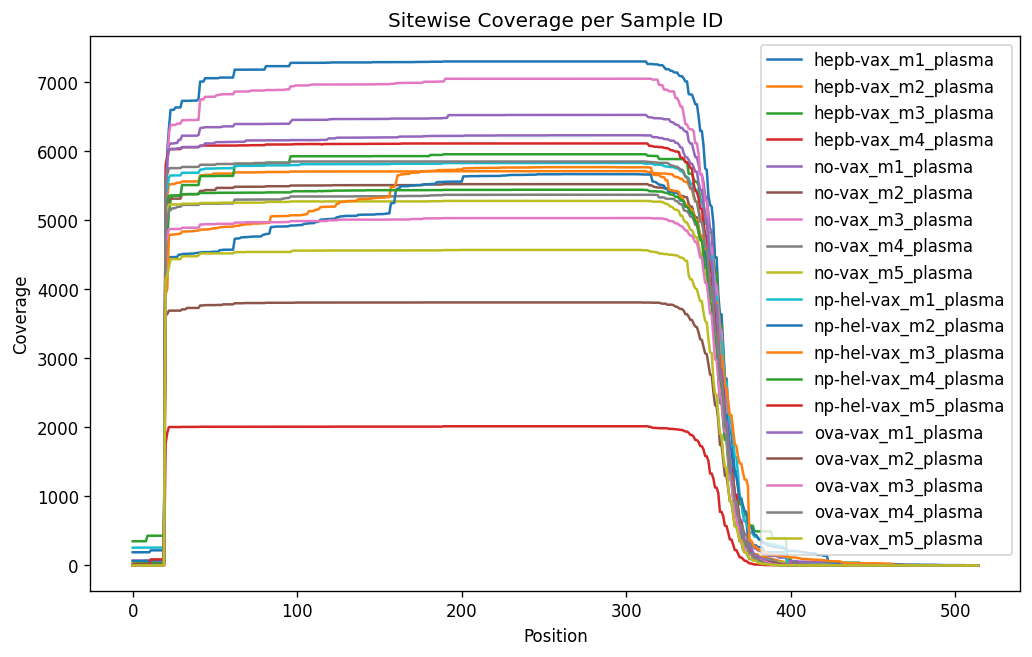

In [7]:
coverage = {}

max_seq_len = df["parent"].str.len().max()

# Iterate through the DataFrame
for index, row in df.iterrows():
    sample_id = row['sample_id']
    sequence = row['parent']

    # Initialize the coverage list for new sample_ids
    if sample_id not in coverage:
        coverage[sample_id] = [0] * max_seq_len

    # Increment coverage for non-'N' bases
    for i, base in enumerate(sequence):
        if base != 'N':
            coverage[sample_id][i] += 1

# Convert coverage dictionary to a DataFrame for plotting
coverage_df = pd.DataFrame(coverage)

# Plotting
plt.figure(figsize=(10, 6))
for sample_id in coverage_df.columns:
    plt.plot(coverage_df[sample_id], label=sample_id)

plt.xlabel('Position')
plt.ylabel('Coverage')
plt.title('Sitewise Coverage per Sample ID')
plt.legend()
plt.show()
